# RL and Advanced DL: Домашнее задание 3

- Третье домашнее задание посвящено порождающим моделям, а точнее — порождающим состязательным сетям. Это самое маленькое и самое техническое задание в курсе, но что уж поделать. Как обычно, **в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии**. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

In [1]:
import random

from tqdm import tqdm
from glob import glob

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from PIL import Image
from itertools import chain
from IPython.display import display
from torch.autograd import Variable
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

%matplotlib inline
plt.style.use('ggplot')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Часть первая: перенос стиля при помощи pix2pix

В этом задании мы будем реализовывать перенос стиля на спаренных данных (paired data). Из стандартных датасетов я выбрал самый маленький -- давайте реализуем перенос стиля из масок сегментации в “настоящие фотографии” для конкретного случая фасадов домов.

Датасет можно скачать здесь (и во многих других местах, должно быть ~29 мегабайт).
В первой части подразумевается реализация pix2pix архитектуры, т.е. генератора и дискриминатора, которые получают на вход условие в виде изображения исходного стиля (подробнее см. лекцию и собственно Isola et al., 2016).

In [9]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
!tar -xf facades.tar.gz

--2021-12-18 16:55:06--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz’

facades.tar.gz      100%[===================>]  28.77M  1.39MB/s    in 16s     

2021-12-18 16:55:23 (1.75 MB/s) - ‘facades.tar.gz’ saved [30168306/30168306]



In [3]:
class FacadesDataset(Dataset):
    def __init__(self, path):
        self.files = glob(path + '/*.jpg');
        self.transformers = transforms.Compose([transforms.ToTensor()])
        
    def __getitem__(self, index):
        img = Image.open(self.files[index]).convert("RGB")    
        return (
            self.transformers(img.crop((256, 0, 512, 256))), 
            self.transformers(img.crop((0, 0, 256, 256)))
        )
    
    def __len__(self):
        return len(self.files)

In [4]:
class Generator(nn.Module):
    def __init__(self, size=64):
        super(Generator, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, size, kernel_size=3, padding=1),
            nn.InstanceNorm2d(size, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(size, size, kernel_size=3, padding=1),
            nn.InstanceNorm2d(size, affine=True),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(size, size*2, kernel_size=3, padding=1),
            nn.InstanceNorm2d(size*2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(size*2, size*2, kernel_size=3, padding=1),
            nn.InstanceNorm2d(size*2, affine=True),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(size*2, size*4, kernel_size=3, padding=1),
            nn.InstanceNorm2d(size*4, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(size*4, size*4, kernel_size=3, padding=1),
            nn.InstanceNorm2d(size*4, affine=True),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(size*4, size*8, kernel_size=3, padding=1),
            nn.InstanceNorm2d(size*8, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(size*8, size*8, kernel_size=3, padding=1),
            nn.InstanceNorm2d(size*8, affine=True),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.deconv1 = nn.Sequential(
            nn.Conv2d(size*12, size*4, kernel_size=3, padding=1),
            nn.InstanceNorm2d(size*4, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(size*4, size*4, kernel_size=3, padding=1),
            nn.InstanceNorm2d(size*4, affine=True),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.deconv2 = nn.Sequential(
            nn.Conv2d(size*6, size*2, kernel_size=3, padding=1),
            nn.InstanceNorm2d(size*2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(size*2, size*2, kernel_size=3, padding=1),
            nn.InstanceNorm2d(size*2, affine=True),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.deconv3 = nn.Sequential(
            nn.Conv2d(size*3, size, kernel_size=3, padding=1),
            nn.InstanceNorm2d(size, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(size, size, kernel_size=3, padding=1),
            nn.InstanceNorm2d(size, affine=True),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.deconv4 = nn.Conv2d(size, 3, kernel_size=1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self._upsample = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
    def forward(self, x):
        conv1 = self.conv1(F.dropout(x))
        x = self.pool(conv1)
        conv2 = self.conv2(F.dropout(x))
        x = self.pool(conv2)
        conv3 = self.conv3(F.dropout(x))
        x = self.pool(conv3)
        x = self.pool(self.conv4(x))
        
        x = self.deconv1(torch.cat([self._upsample(x), conv3], dim=1))
        x = self.deconv2(torch.cat([self.upsample(x), conv2], dim=1))
        x = self.deconv3(torch.cat([self.upsample(x), conv1], dim=1))
        return torch.sigmoid(self.deconv4(x))

In [5]:
class Discriminator(nn.Module):
    def __init__(self, size=64):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3*2, size, kernel_size=3, padding=1),
            nn.InstanceNorm2d(size, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(size, size, kernel_size=3, padding=1),
            nn.InstanceNorm2d(size, affine=True),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(size, size*2, kernel_size=3, padding=1),
            nn.InstanceNorm2d(size*2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(size*2, size*2, kernel_size=3, padding=1),
            nn.InstanceNorm2d(size*2, affine=True),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(size*2, size*4, kernel_size=3, padding=1),
            nn.InstanceNorm2d(size*4, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(size*4, size*4, kernel_size=3, padding=1),
            nn.InstanceNorm2d(size*4, affine=True),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(size*4, size*8, kernel_size=3, padding=1),
            nn.InstanceNorm2d(size*8, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(size*8, size*8, kernel_size=3, padding=1),
            nn.InstanceNorm2d(size*8, affine=True),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(size*8, 2)
        
    def forward(self, x, val=None):
        x = torch.cat([x, val], dim=1)
        x = self.pool(self.conv1(x))
        x = F.dropout(x)
        x = self.pool(self.conv2(x))
        x = F.dropout(x)
        x = self.pool(self.conv3(x))
        x = F.dropout(x)
        x = self.pool(self.conv4(x))
        x = F.dropout(x)
        x = self.avgpool(x).squeeze(-1).squeeze(-1)
        return self.linear(x)

In [6]:
mod_gen = Generator().to(device)
opt_gen = Adam(mod_gen.parameters(), lr=3e-4, betas=(0.5, 0.999))
sch_gen = lr_scheduler.StepLR(opt_gen, 100)
mod_gen

Generator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256

In [7]:
mod_dis = Discriminator().to(device)
opt_dis = Adam(mod_dis.parameters(), lr=3e-4, betas=(0.5, 0.999))
sch_dis = lr_scheduler.StepLR(opt_dis, 100)
mod_dis

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128,

In [10]:
train = DataLoader(FacadesDataset('facades/train'), 8, shuffle=True)
test = DataLoader(FacadesDataset('facades/test'), 8, shuffle=False)
valid = DataLoader(FacadesDataset('facades/val'), 8, shuffle=True)

In [11]:
epochs = 20
loss_gen, loss_dis = [], []
for epoch in tqdm(range(epochs)):
    for val, image_true in train:
        val = val.to(device)
        image_true = image_true.to(device)
        
        mod_gen.eval()
        mod_dis.train()
        opt_dis.zero_grad()

        image_pred = mod_gen(val)
        dis_img = mod_dis(val, image_pred)
        dis_loss_pred = F.cross_entropy(
            dis_img,
            torch.zeros(dis_img.shape[0]).long().to(device)
        )
        dis_img = mod_dis(val, image_true)
        dis_loss_true = F.cross_entropy(
            dis_img,
            torch.ones(dis_img.shape[0]).long().to(device)
        )
        dis_loss = (dis_loss_pred + dis_loss_true) * 0.5
        
        dis_loss.backward()
        opt_dis.step()
        loss_dis.append(dis_loss.item())
        
        mod_gen.train()
        mod_dis.eval()
        opt_gen.zero_grad()

        image_pred = mod_gen(val)
        dis_img = mod_dis(val, image_pred)
        gen_loss_pred = F.cross_entropy(
            dis_img,
            torch.ones(dis_img.shape[0]).long().to(device)
        )
        gen_loss_true = F.l1_loss(
            image_pred,
            image_true
        )
        
        gen_loss = gen_loss_pred + 100 * gen_loss_true
        gen_loss.backward()
        opt_gen.step()
        loss_gen.append(gen_loss.item())
        
    sch_gen.step()
    sch_dis.step()

    if (epoch + 1) % 5 == 0:
        print(f'Epoch: {epoch + 1}, loss generator: {np.mean(loss_gen)}, loss discriminator: {np.mean(loss_dis)}"')

 25%|██▌       | 5/20 [19:23<58:10, 232.70s/it]  

Epoch: 5, loss generator: 20.34089423370361, loss discriminator: 0.3623756881952286"


 50%|█████     | 10/20 [38:46<38:45, 232.55s/it]

Epoch: 10, loss generator: 20.57233033370972, loss discriminator: 0.3790944844186306"


 75%|███████▌  | 15/20 [58:10<19:24, 232.89s/it]

Epoch: 15, loss generator: 20.616349365234374, loss discriminator: 0.38228496752182645"


100%|██████████| 20/20 [1:17:42<00:00, 233.10s/it]

Epoch: 20, loss generator: 20.617596042633057, loss discriminator: 0.3843310199677944"


In [12]:
def plot_mean_loss(loss, title=''):
    plt.figure(figsize=(16, 8))
    plt.plot(loss)
    plt.title(title)
    plt.xlabel('Эпохи')
    plt.ylabel('Потери')
    plt.show()
    print("Среднее значение потерь", np.mean(loss))

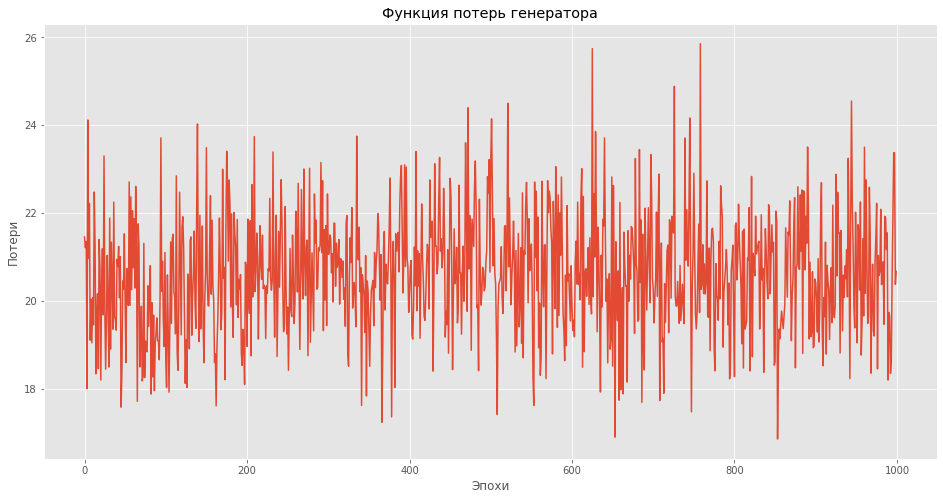

Среднее значение потерь 20.617596042633057


In [13]:
plot_mean_loss(loss_gen, 'Функция потерь генератора')

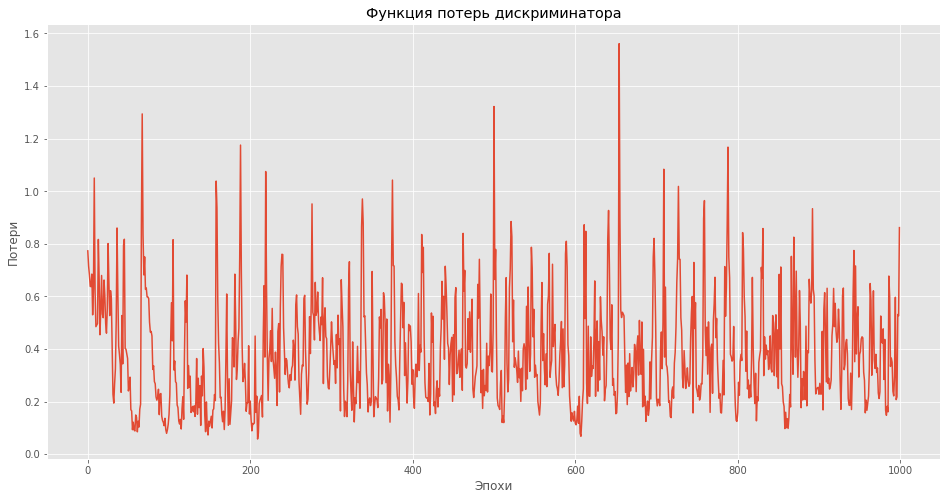

Среднее значение потерь 0.3843310199677944


In [14]:
plot_mean_loss(loss_dis, 'Функция потерь дискриминатора')

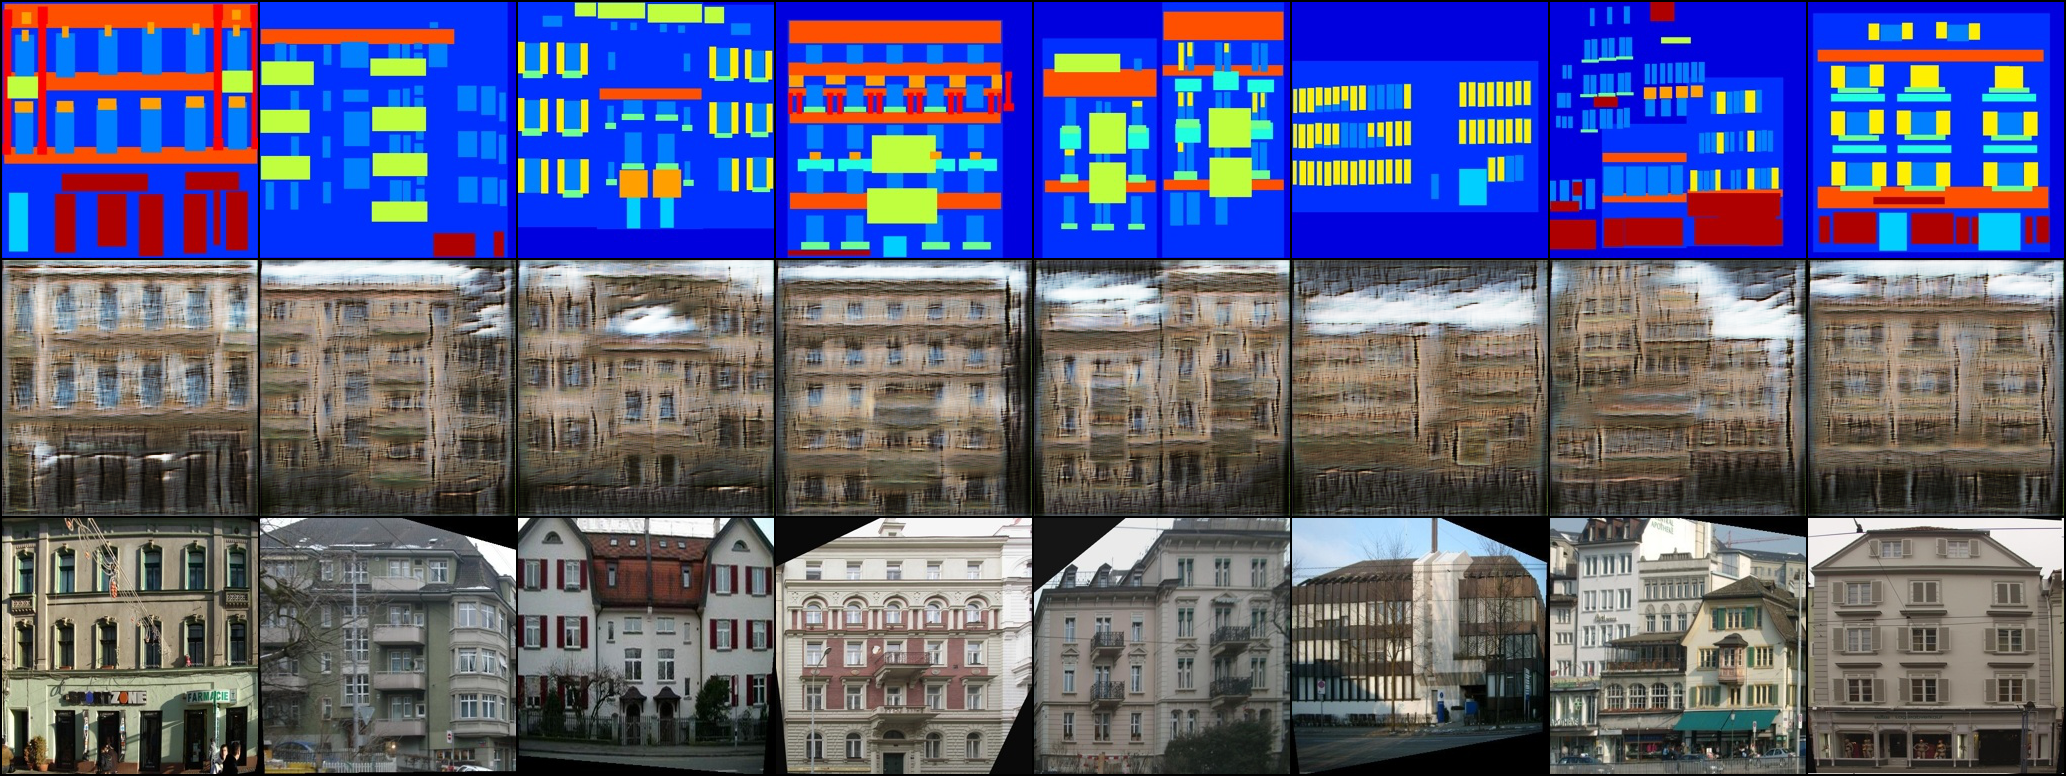

In [ ]:
mod_gen.eval()
for val, img in test:
    val = val.to(device)
    img_pred = torch.cat(
        [val.cpu(), mod_gen(val).cpu().detach(), img], 
        dim=0
    )
    display(transforms.ToPILImage()(utils.make_grid(img_pred)))

### Вывод:
Сгенерированные изображенния получаются довольно неплохими и похожими на изначальные изображения. Запустил только 20 эпох, так как не хватило времени и мощностей на колабе. При 50 эпохах результаты намного лучше.

К сожалению, к концу года не хватило времени реализовать циклы и протестировать более сложные архитектуры с добавлением нормализации и подбором гиперпараметров.

## Часть вторая: добавим циклы

Вторая часть -- реализация CycleGAN. Предлагается на том же датасете реализовать базовую конструкцию CycleGAN для unpaired style transfer, то есть переноса стилей, каждый из которых задан неразмеченным датасетом (подробнее см. лекцию и собственно Zhu et al., 2017).

В качестве опционального задания за немного дополнительных баллов здесь предлагаю найти дополнительные данные такого рода (фасады и их карты сегментации) и улучшить качество переноса стиля за счёт обучения на датасете побольше. Данные, скорее всего, будут unpaired, поэтому эта часть скорее релевантна CycleGAN.
